# Background blurring using single image

In [35]:
# System imports
from os import path
import math

# Third-Party Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np

# modify to where you store your project data including utils
datadir = "./" 

# can change this to your output directory of choice
!mkdir "images"
!mkdir "images/inputs"
!mkdir "images/outputs"

mkdir: images: File exists


mkdir: images/inputs: File exists
mkdir: images/outputs: File exists


## Part 2: Background Blur using Depth Image

In [36]:
'''
  The given position will be clear
  The other regions will be blurred based on the depth map

  dimg: depth image
  cimg: color image
  pos: position of the object to be clear
  blur_lv: blur level

  return: blurred image
  '''
def blur_background(dimg, cimg, pos, blur_lv=5, step=1):
  assert dimg.shape == cimg.shape[:2]

  # set up constants
  h,w = dimg.shape
  furthest = np.max(dimg)
  closest = np.min(dimg)
  focus_depth = dimg[pos[0], pos[1]]

  # divide the depth range into blur_lv levels. d is the depth range of each level
  dr = max(abs(furthest - focus_depth), abs(focus_depth - closest)) / (blur_lv)

  # given a depth, calculate its blur level
  def calc_level(x):
    nonlocal focus_depth
    if x == focus_depth:
      return 0

    return int(abs(int(x) - int(focus_depth)) / dr)
  
  # create multiple blurred images based on blur level
  blurred_imgs = [cimg.copy()]
  for i in range(blur_lv):
    kernel_size = 2 * step * i + 3
    blurred_imgs.append(cv2.GaussianBlur(cimg, (kernel_size, kernel_size), 0))

  # combine the blurred images based on the blur level at each pixel
  # get the pixel from the corresponding blurred image
  output = np.zeros((h,w,3),dtype=np.uint8)
  level_image = np.zeros((h,w),dtype=np.uint8)
  for i in range(h):
    for j in range(w):
      calculated_level = calc_level(dimg[i,j])
      output[i,j] = blurred_imgs[calculated_level][i,j]
      level_image[i,j] = calculated_level
  return (output, level_image)

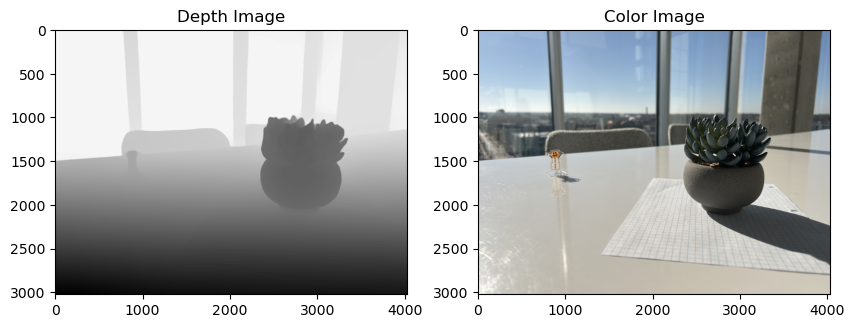

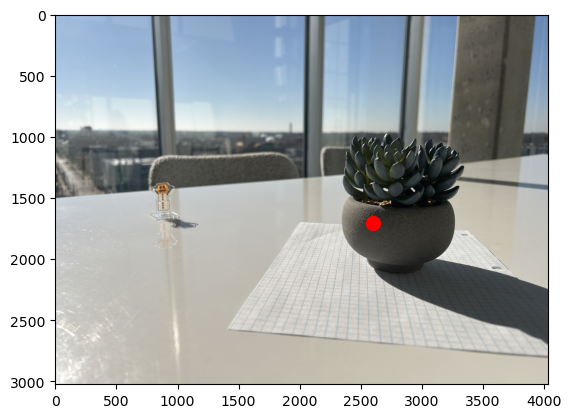

In [37]:
# read depth image and color image
dimg = cv2.imread("images/inputs/d4.png", cv2.IMREAD_ANYDEPTH)
cimg = cv2.imread("images/inputs/c4.JPG")
cimg = cv2.cvtColor(cimg, cv2.COLOR_BGR2RGB)

# invert depth image TODO: change the rest of the code to avoid this inversion
dimg = np.max(dimg) - dimg

# # parameters for pairs 3
# position = (int(cimg.shape[0]/2), int(cimg.shape[1]/2))
# blur_lv = 20
# step = 1

# # parameters for pairs 2
# position = (840, 1080)
# blur_lv = 20
# step = 1

# parameters for pairs 4
position = (1700, 2600)
blur_lv = 20
step = 2



# show depth image
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(dimg, cmap='gray')
plt.title("Depth Image")
plt.subplot(1,2,2)
plt.imshow(cimg)
plt.title("Color Image")
plt.show()

# show the focus position
plt.figure()
plt.imshow(cimg)
plt.scatter(position[1], position[0], c='r', s=100)
plt.show()

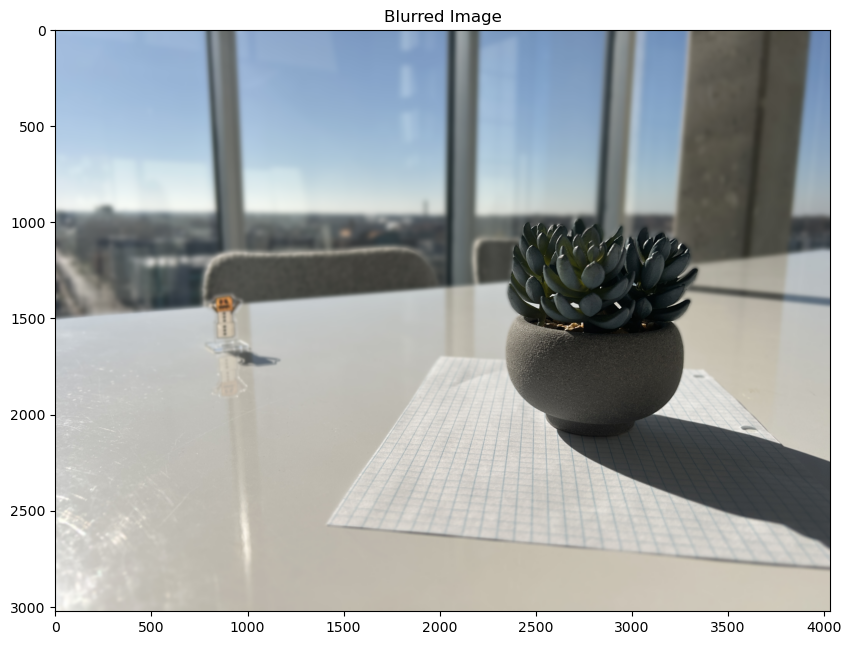

True

In [38]:
(result, level_image) = blur_background(dimg, cimg, position, blur_lv=blur_lv, step=step)
# show blurred image
plt.figure(figsize=(10,10))
plt.imshow(result)
plt.title("Blurred Image")
plt.show()

# from RGB to BGR
result = result[:,:,::-1]
# write blurred image
cv2.imwrite("images/outputs/blur.png", result)

## Part 3: Reducing edge blurring using Depth Image

We observe that the edges of the foreground object are also blurred. This is because the Gaussian blurring of the background image is using the pixels of the foreground object. To avoid this, we want to do the following steps:

1. Create a mask of the foreground object
2. Do some simple hole filling to fill in the holes in the mask
3. The rest is the same as before.

In [39]:
# Step 1: create a mask for the selected object.
# Naively, we simply build a mask that excludes all pixels that are not blurred.

def create_mask(level_image, blur_lv):
  mask = np.zeros(level_image.shape, dtype=np.uint8)
  mask[level_image != blur_lv] = 255
  return mask

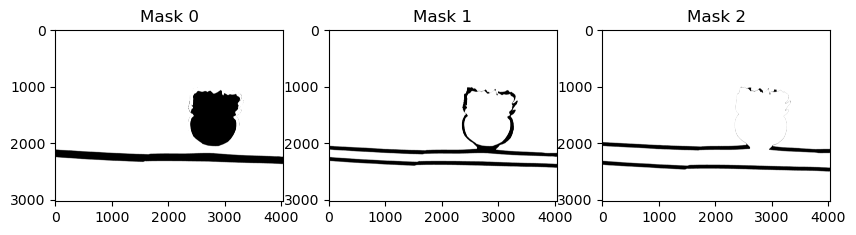

In [40]:
# pring the mask

mask_arr = []
for i in range(blur_lv):
  mask_arr.append(create_mask(level_image, i))

# show the first three masks
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(mask_arr[0], cmap='gray')
plt.title("Mask 0")
plt.subplot(1,3,2)
plt.imshow(mask_arr[1], cmap='gray')
plt.title("Mask 1")
plt.subplot(1,3,3)
plt.imshow(mask_arr[2], cmap='gray')
plt.title("Mask 2")
plt.show()